## COMP5623 Coursework on Image Classification with Convolutional Neural Networks 

Starter code.

In [0]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from  torch.utils.data import Dataset, DataLoader

from sklearn.metrics import confusion_matrix
from skimage import io, transform

import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import csv
import os
import math
import cv2
import timeit

### Part I

The first part of the assignment is to build a CNN and train it on a subset of the ImageNet dataset. We will first create a dataframe with all the references to the images and their labels.

To download the images into your work environment, clone into a git respository containing the images.

In [389]:
! git clone https://github.com/MohammedAlghamdi/imagenet10.git

fatal: destination path 'imagenet10' already exists and is not an empty directory.


We check that the repository is there:

In [390]:
! ls

imagenet10  my_convNet_model.pth  sample_data


In [0]:
root_dir = "imagenet10/train_set/"
class_names = [
  "baboon",
  "banana",
  "canoe",
  "cat",
  "desk",
  "drill",
  "dumbbell",
  "football",
  "mug",
  "orange",
]

A helper function for reading in images and assigning labels.

In [0]:
def get_meta(root_dir, dirs):
    """ Fetches the meta data for all the images and assigns labels.
    """
    paths, classes = [], []
    for i, dir_ in enumerate(dirs):
        for entry in os.scandir(root_dir + dir_):
            if (entry.is_file()):
                paths.append(entry.path)
                classes.append(i)
                
    return paths, classes

We create a dataframe using all the data.

In [0]:
paths, classes = get_meta(root_dir, class_names)

data = {
    'path': paths,
    'class': classes
}

data_df = pd.DataFrame(data, columns=['path', 'class'])
data_df = data_df.sample(frac=1).reset_index(drop=True) # Shuffles the data

View some sample data.

In [395]:
print("Found", len(data_df), "images.")
data_df.head()

Found 9000 images.


,path,class
0,imagenet10/train_set/football/n04254680_1298.JPEG,7
1,imagenet10/train_set/orange/n07747607_4431.JPEG,9
2,imagenet10/train_set/banana/n07753592_6639.JPEG,1
3,imagenet10/train_set/cat/n02123159_5244.JPEG,3
4,imagenet10/train_set/dumbbell/n03255030_11346....,6


We create the Dataset class.

In [0]:
class ImageNet10(Dataset):
    """ ImageNet10 dataset. """

    def __init__(self, df, transform=None):
        """
        Args:
            image_dir (string): Directory with all the images
            df (DataFrame object): Dataframe containing the images, paths and classes
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load image from path and get label
        x = Image.open(self.df['path'][index])
        try:
          x = x.convert('RGB') # To deal with some grayscale images in the data
        except:
          pass
        y = torch.tensor(int(self.df['class'][index]))

        if self.transform:
            x = self.transform(x)

        return x, y

Compute what we should normalise the dataset to.

In [0]:
def compute_img_mean_std(image_paths):
    """
        Author: @xinruizhuang. Computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255. #reduce pixel values to values from 0-1 (normalization)

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means, stdevs


In [398]:
norm_mean, norm_std = compute_img_mean_std(paths)

100%|██████████| 9000/9000 [00:48<00:00, 183.68it/s]


(224, 224, 3, 9000)
normMean = [0.5228359, 0.4798834, 0.40605333]
normStd = [0.29770732, 0.28883994, 0.31178218]


We create the transforms to normalise and turn our data into tensors.

In [0]:
data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

We split the data into train, validation and test sets and instantiate our new ImageNet10 Dataset objects.

In [0]:
train_split = 0.80 # Defines the ratio of train/valid/test data.
valid_split = 0.10

train_size = int(len(data_df)*train_split)
valid_size = int(len(data_df)*valid_split)

ins_dataset_train = ImageNet10(
    df=data_df[:train_size],
    transform=data_transform,
)

ins_dataset_valid = ImageNet10(
    df=data_df[train_size:(train_size + valid_size)].reset_index(drop=True),
    transform=data_transform,
)

ins_dataset_test = ImageNet10(
    df=data_df[(train_size + valid_size):].reset_index(drop=True),
    transform=data_transform,
)

We create DataLoaders for the datasets.

In [0]:
train_loader = DataLoader(
    ins_dataset_train,
    batch_size=100,
    shuffle=True,
    num_workers=2
)

valid_loader = DataLoader(
    ins_dataset_valid,
    batch_size=10,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    ins_dataset_test,
    batch_size=24,
    shuffle=False,
    num_workers=2
)

## **Building the network**


A framework for the ConvNet model:

### 3 convolutional layers (Default configuration)

In [0]:
# Model Building
# Convolutional neural network
class ConvNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
  
        # Network layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=24, kernel_size=4)
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size=4) 

        self.fc1 = nn.Linear(288, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=num_classes)
        
    def forward(self, x):      
        x = F.dropout(F.max_pool2d(F.relu(self.conv1(x)), kernel_size=4), p=0.3)
        x = F.dropout(F.max_pool2d(F.relu(self.conv2(x)), kernel_size=4), p=0.3)
        x = F.dropout(F.max_pool2d(F.relu(self.conv3(x)), kernel_size=4), p=0.3)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        out = self.fc2(x)

        return out

### 2 convolutional layers



In [0]:
# Model Building
# Convolutional neural network
class ConvNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
  
        # Network layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=24, kernel_size=4) 

        self.fc1 = nn.Linear(24*62*62, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=num_classes)
        
    def forward(self, x):      
        x = F.dropout(F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2), p=0.3)
        x = F.dropout(F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2), p=0.3)
        
        x = torch.flatten(x, 1) #Flatten tensor
        
        x = self.fc1(x)
        out = self.fc2(x)

        return out

### 4 convolutional layers

In [0]:
# Model Building
# Convolutional neural network
class ConvNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
  
        # Network layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=24, kernel_size=4)
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size=4)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=40, kernel_size=4) 

        self.fc1 = nn.Linear(40, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=num_classes)
        
    def forward(self, x):      
        x = F.dropout(F.max_pool2d(F.relu(self.conv1(x)), kernel_size=3), p=0.3)
        x = F.dropout(F.max_pool2d(F.relu(self.conv2(x)), kernel_size=3), p=0.3)
        x = F.dropout(F.max_pool2d(F.relu(self.conv3(x)), kernel_size=3), p=0.3)
        x = F.dropout(F.max_pool2d(F.relu(self.conv4(x)), kernel_size=3), p=0.3)

        x = torch.flatten(x, 1) #Flatten tensor

        x = self.fc1(x)
        out = self.fc2(x)

        return out

### 5 convolutional layers

In [0]:
# Model Building
# Convolutional neural network
class ConvNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
  
        # Network layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=24, kernel_size=4)
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size=4)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=40, kernel_size=4)
        self.conv5 = nn.Conv2d(in_channels=40, out_channels=48, kernel_size=4) 

        self.fc1 = nn.Linear(48*5*5, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=num_classes)
        
    def forward(self, x):      
        x = F.dropout(F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2), p=0.3)
        x = F.dropout(F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2), p=0.3)
        x = F.dropout(F.max_pool2d(F.relu(self.conv3(x)), kernel_size=2), p=0.3)
        x = F.dropout(F.max_pool2d(F.relu(self.conv4(x)), kernel_size=2), p=0.3)
        x = F.dropout(F.max_pool2d(F.relu(self.conv5(x)), kernel_size=2), p=0.3)

        x = torch.flatten(x, 1) #Flatten tensor

        x = self.fc1(x)
        out = self.fc2(x)

        return out

## **Training the network & filter visualization**

In [0]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

In [0]:
def visualise_filters(layer):  
  filters = layer.weight.data
  
  if filters.is_cuda:
    filters = filters.cpu()
  
  filters = filters.numpy()
  filters = (filters - np.min(filters))/(np.max(filters) - np.min(filters)) #normalize filter

  fig = plt.figure(figsize=(22,5))
  for i, filter in enumerate(filters):
    for j, channel in enumerate(filter):
      plt.subplot(3, 16, j*16 + i+1).set_title(f"F: {i+1} C: {'R' if j+1 == 1 else 'G' if j+1 == 2 else 'B'}")
      plt.imshow(channel, cmap="gray")
      plt.axis('off')

  fig.show()

In [408]:
# Device configuration - defaults to CPU unless GPU is available on device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [0]:
convNet_gpu = ConvNet().to(device)

training_losses = []
validation_losses = []

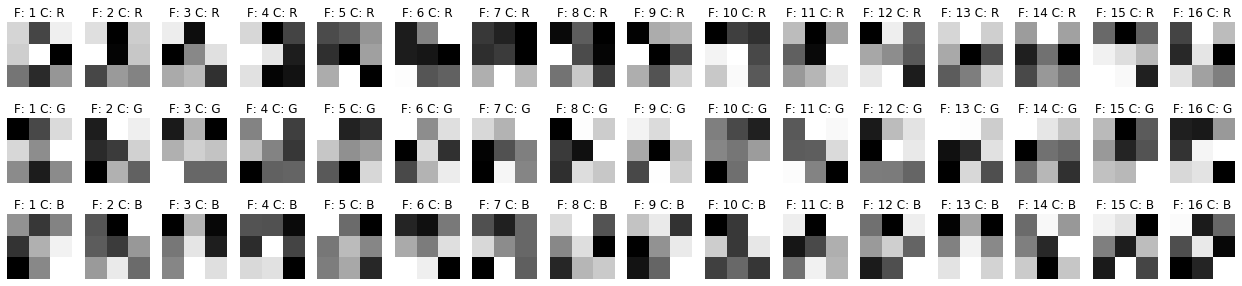

In [78]:
# Visualize filters of first layer of convNet_gpu before training
visualise_filters(convNet_gpu.conv1)

In [0]:
# Training on GPU
def train_model_epochs_gpu(num_epochs):

  optimizer = optim.SGD(convNet_gpu.parameters(), lr=0.001, momentum=0.9)
  output_file = "my_convNet_model.pth"

  valid_loss_min = np.inf

  for epoch in range(num_epochs):

    train_loss = 0
    valid_loss = 0
    total_correct = 0

    if epoch == num_epochs/2:
      visualise_filters(convNet_gpu.conv1)

    convNet_gpu.train()
    for i, batch in enumerate(train_loader, 0):
      images, labels = batch

      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      preds = convNet_gpu(images)
      loss = F.cross_entropy(preds, labels) # Loss calculation

      loss.backward() # Calculating the gradients
      optimizer.step() # Updating the weights

      train_loss += loss.item() * images.size(0)
      total_correct += get_num_correct(preds, labels)

    convNet_gpu.eval()
    for i, batch in enumerate(valid_loader, 0):
      images, labels = batch

      images = images.to(device)
      labels = labels.to(device)

      preds = convNet_gpu(images)
      loss = F.cross_entropy(preds, labels) # Loss calculation

      valid_loss += loss.item() * images.size(0)
      total_correct += get_num_correct(preds, labels)

    # Calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)

    print("epoch:", epoch, "total_correct: ", total_correct, "train loss: ", train_loss, "valid loss: ", valid_loss)

    training_losses.append(train_loss)
    validation_losses.append(valid_loss)

    # Save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
      torch.save(convNet_gpu.state_dict(), output_file)
      valid_loss_min = valid_loss




In [0]:
gpu_train_time = timeit.timeit(
    "train_model_epochs_gpu(num_epochs)",
    #setup="num_epochs=10",
    setup="num_epochs=35",
    number=1,
    globals=globals(),
)

epoch: 0 total_correct:  890 train loss:  2.294894880718655 valid loss:  2.270623556772868
Validation loss decreased (inf --> 2.270624).  Saving model ...
epoch: 1 total_correct:  1375 train loss:  2.2399536636140613 valid loss:  2.1790610366397436
Validation loss decreased (2.270624 --> 2.179061).  Saving model ...
epoch: 2 total_correct:  1714 train loss:  2.1107713497347302 valid loss:  2.04639134671953
Validation loss decreased (2.179061 --> 2.046391).  Saving model ...
epoch: 3 total_correct:  1901 train loss:  2.0219661974244647 valid loss:  1.9958216892348395
Validation loss decreased (2.046391 --> 1.995822).  Saving model ...
epoch: 4 total_correct:  2055 train loss:  1.9871763669782214 valid loss:  1.9608474254608155
Validation loss decreased (1.995822 --> 1.960847).  Saving model ...
epoch: 5 total_correct:  2194 train loss:  1.9634834461741977 valid loss:  1.9369797613885669
Validation loss decreased (1.960847 --> 1.936980).  Saving model ...
epoch: 6 total_correct:  2326 tr

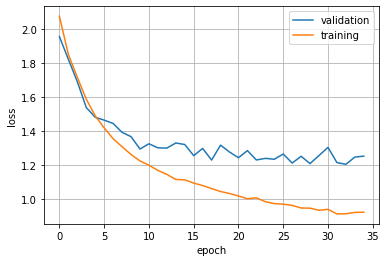

In [381]:
val_plot, = plt.plot(validation_losses, label='validation')
train_plot, = plt.plot(training_losses, label='training')
plt.legend(handles=[val_plot, train_plot])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

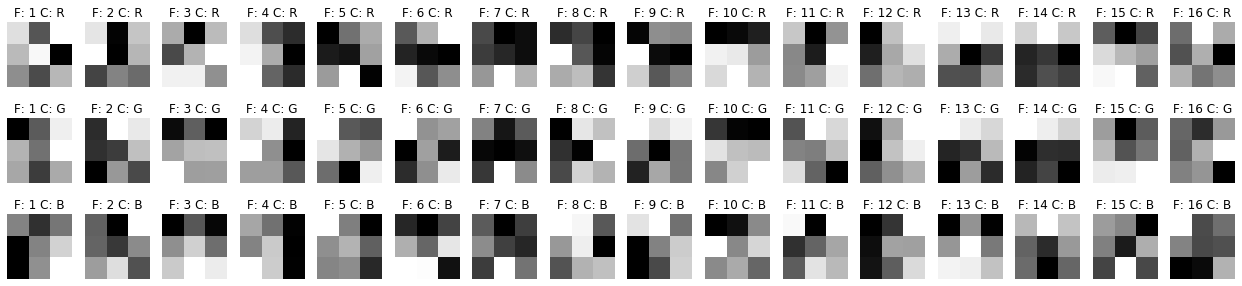

In [82]:
# Visualize filters of first layer of convNet_gpu after training
visualise_filters(convNet_gpu.conv1)

In [382]:
# Load the model with the lowest validation loss
convNet_gpu = ConvNet().to(device)
convNet_gpu.load_state_dict(torch.load('my_convNet_model.pth', map_location=device))

<All keys matched successfully>

## **Testing the network**

In [383]:
correct = 0
total = 0
all_preds = torch.tensor([])
all_preds = all_preds.to(device)

# Why don't we need gradients? What happens if we do include gradients?
with torch.no_grad():
    
    # Iterate over the test set
    for data in test_loader:
        images, labels = data

        images = images.to(device)
        labels = labels.to(device)
        
        outputs = convNet_gpu(images)
        
        # torch.max is an argmax operation
        _, preds = torch.max(outputs.data, 1)

        all_preds = torch.cat(
            (all_preds, outputs)
            ,dim=0
        )
        
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 63 %


In [0]:
len(ins_dataset_test)

1800

In [384]:
all_labels = torch.tensor(ins_dataset_test.df['class'])
all_labels

tensor([3, 8, 0, 9, 3, 4, 4, 4, 2, 4, 1, 7, 4, 4, 5, 1, 0, 9, 8, 8, 2, 6, 4, 6,
        6, 8, 3, 1, 7, 6, 0, 6, 2, 0, 0, 5, 4, 8, 1, 8, 4, 7, 2, 7, 7, 6, 1, 6,
        1, 1, 7, 1, 7, 9, 7, 6, 3, 9, 1, 6, 3, 1, 1, 4, 7, 8, 0, 9, 6, 0, 4, 7,
        2, 5, 4, 8, 5, 9, 9, 2, 7, 4, 8, 5, 8, 6, 7, 1, 9, 9, 6, 0, 3, 4, 2, 0,
        8, 6, 7, 0, 9, 5, 2, 2, 1, 7, 9, 3, 4, 2, 9, 3, 1, 7, 0, 7, 3, 3, 2, 5,
        8, 4, 4, 8, 4, 1, 0, 4, 0, 2, 7, 1, 8, 4, 9, 3, 7, 3, 3, 6, 0, 4, 8, 1,
        7, 9, 2, 1, 8, 3, 8, 4, 5, 6, 0, 2, 7, 6, 6, 7, 1, 2, 8, 3, 3, 8, 2, 0,
        5, 8, 9, 9, 7, 3, 6, 7, 2, 9, 6, 6, 2, 5, 1, 0, 7, 8, 9, 9, 4, 3, 5, 2,
        6, 6, 3, 9, 6, 9, 2, 7, 5, 9, 4, 6, 5, 3, 8, 5, 3, 5, 5, 8, 7, 7, 4, 2,
        3, 1, 1, 8, 5, 1, 9, 7, 6, 9, 0, 4, 6, 9, 4, 0, 0, 4, 0, 4, 8, 2, 5, 9,
        5, 0, 2, 4, 9, 4, 6, 1, 7, 1, 6, 5, 6, 2, 1, 2, 1, 4, 0, 4, 1, 3, 4, 3,
        5, 5, 3, 3, 2, 1, 1, 7, 4, 1, 0, 0, 2, 5, 1, 9, 0, 3, 3, 0, 5, 5, 6, 0,
        7, 1, 7, 1, 6, 6, 3, 6, 5, 0, 2,

In [385]:
all_preds = all_preds.cpu()
all_preds.argmax(dim=1)

tensor([3, 4, 7, 9, 3, 4, 4, 4, 2, 4, 7, 7, 2, 8, 5, 1, 0, 9, 8, 8, 2, 4, 4, 6,
        8, 7, 2, 1, 7, 6, 2, 7, 2, 7, 0, 6, 8, 8, 6, 6, 4, 7, 2, 7, 7, 0, 1, 6,
        1, 1, 5, 1, 7, 9, 7, 6, 3, 9, 7, 1, 3, 9, 1, 4, 6, 8, 7, 9, 6, 0, 4, 7,
        2, 6, 4, 8, 5, 9, 1, 2, 2, 8, 8, 5, 8, 6, 7, 1, 9, 9, 6, 0, 7, 4, 7, 0,
        8, 6, 7, 0, 9, 8, 2, 7, 1, 6, 1, 3, 4, 2, 3, 3, 9, 7, 0, 7, 3, 0, 8, 5,
        7, 4, 8, 2, 4, 1, 6, 4, 8, 2, 3, 1, 8, 8, 9, 5, 7, 8, 6, 6, 0, 4, 8, 8,
        7, 9, 2, 1, 8, 3, 6, 8, 5, 6, 0, 2, 8, 5, 5, 0, 1, 4, 8, 3, 3, 8, 2, 0,
        6, 8, 9, 9, 7, 3, 1, 8, 4, 1, 6, 4, 2, 5, 8, 0, 7, 8, 8, 9, 4, 7, 3, 2,
        6, 6, 3, 9, 6, 1, 8, 7, 6, 9, 8, 7, 6, 1, 8, 8, 3, 8, 1, 7, 7, 8, 4, 0,
        3, 1, 8, 8, 5, 1, 9, 7, 6, 8, 0, 4, 2, 6, 4, 2, 0, 6, 0, 4, 8, 2, 6, 1,
        4, 0, 7, 4, 9, 2, 8, 8, 8, 1, 4, 5, 4, 4, 1, 3, 8, 4, 0, 6, 1, 3, 8, 0,
        5, 5, 3, 0, 2, 4, 1, 1, 4, 1, 0, 0, 2, 5, 1, 8, 0, 3, 3, 0, 4, 5, 6, 0,
        7, 0, 6, 1, 0, 2, 3, 8, 5, 7, 2,

In [386]:
cm = confusion_matrix(all_labels, all_preds.argmax(dim=1))
cm

array([[61,  1,  2,  5,  0,  0,  3,  7,  2,  0],
       [ 2, 61,  0,  1,  1,  1,  1,  8, 10,  7],
       [ 5,  0, 62,  3,  5,  1,  0,  8,  5,  0],
       [15,  5,  1, 57,  2,  1,  5,  8,  3,  0],
       [ 0,  1,  2,  0, 64,  1,  6,  0, 17,  0],
       [ 1,  1,  3,  2,  5, 27, 21,  8,  9,  1],
       [ 2,  3,  3,  1,  8,  6, 51,  7, 12,  0],
       [ 3,  5,  2,  3,  2,  2, 10, 59,  6,  0],
       [ 1,  4,  2,  1,  5,  0,  7,  8, 68,  0],
       [ 0, 16,  1,  2,  0,  2,  2,  2,  3, 63]])

In [0]:
import itertools

def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix very prettily.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    # Specify the tick marks and axis text
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    # The data formatting
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Print the text of the matrix, adjusting text colour for display
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

Confusion matrix, without normalization


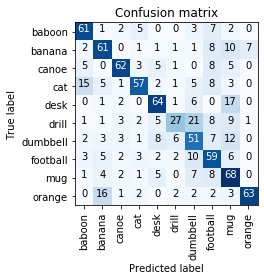

In [388]:
plot_confusion_matrix(cm, class_names)

## Feature Map Visualization

In [0]:
class SaveFeatures():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = torch.tensor(output,requires_grad=True).cuda()
    def close(self):
        self.hook.remove()

In [263]:
list(convNet_gpu.children())

[Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1)),
 Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1)),
 Conv2d(24, 32, kernel_size=(4, 4), stride=(1, 1)),
 Conv2d(32, 40, kernel_size=(4, 4), stride=(1, 1)),
 Linear(in_features=6760, out_features=512, bias=True),
 Linear(in_features=512, out_features=10, bias=True)]

In [0]:
activations = []
for i in range(4):
  activations.append(SaveFeatures(list(convNet_gpu.children())[i]))

In [220]:
activations

In [0]:
extra_loader = torch.utils.data.DataLoader(
    ins_dataset_test,
    batch_size=1,
    shuffle=True,
)

iterator = iter(extra_loader)

In [0]:
image_batch_1, label1 = iterator.next()
image_batch_2, label2 = iterator.next()

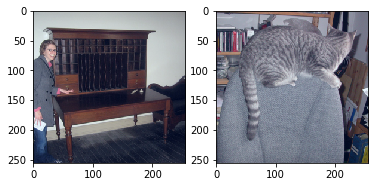

In [266]:
image1 = np.transpose(image_batch_1.squeeze(0).numpy(), (1, 2, 0))
image1 = (image1 - np.min(image1))/(np.max(image1) - np.min(image1)) #normalize image data

image2 = np.transpose(image_batch_2.squeeze(0).numpy(), (1, 2, 0))
image2 = (image2 - np.min(image2))/(np.max(image2) - np.min(image2)) #normalize image data

plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.subplot(1, 2, 2)
plt.imshow(image2)

In [256]:
convNet_gpu.cpu()

ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(24, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(32, 40, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=6760, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

### For first image

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


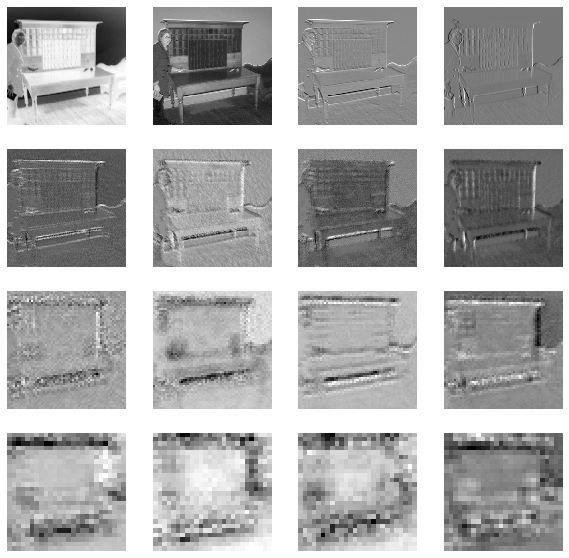

In [267]:
convNet_gpu(image_batch_1)

for layer in convNet_gpu.children():
  for activation in activations:
    for feature in activation.features[0]:
      loss =- feature.mean()
      optimizer = optim.SGD([image_batch_1], lr=0.001, weight_decay=1e-6)
      optimizer.zero_grad()
      optimizer.step()

j = 1
fig = plt.figure(figsize=(10,10))
for activation in activations:
  for i in range(4):
    feature = activation.features[0, i].cpu().detach()

    plt.subplot(4, 4, j)
    plt.imshow(feature, cmap='gray')
    plt.axis('off')
    j = j + 1

fig.show()

### For second image

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


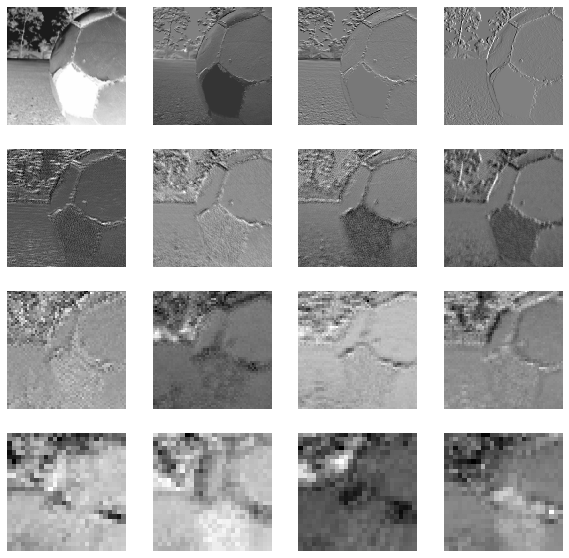

In [261]:
convNet_gpu(image_batch_2)

for layer in convNet_gpu.children():
  for activation in activations:
    for feature in activation.features[0]:
      loss =- feature.mean()
      optimizer = optim.SGD([image_batch_2], lr=0.001, weight_decay=1e-6)
      optimizer.zero_grad()
      optimizer.step()

j = 1
fig = plt.figure(figsize=(10,10))
for activation in activations:
  for i in range(4):
    feature = activation.features[0, i].cpu().detach()

    plt.subplot(4, 4, j)
    plt.imshow(feature, cmap='gray')
    plt.axis('off')
    j = j + 1

fig.show()